In [1]:
# import the libraries
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [31]:
# import the data and fix the column types
base_col_name = 'DEXSIUS'; acct_col_name = 'DEXJPUS'; ccy1ccy2 = 'SGDJPY'
df_base_orig = pd.read_csv('Data/' + base_col_name + '_19810102_20180518.csv', header=0, index_col='DATE')
df_acct_orig = pd.read_csv('Data/' + acct_col_name + '_19710104_20180518.csv', header=0, index_col='DATE')

df_base_orig.index = pd.to_datetime(df_base_orig.index)
df_acct_orig.index = pd.to_datetime(df_acct_orig.index)
df_base_orig = df_base_orig.loc['2010':]
df_acct_orig = df_acct_orig.loc['2010':]

df_base_orig[base_col_name] = pd.to_numeric(df_base_orig[base_col_name], errors='coerce')
df_acct_orig[acct_col_name] = pd.to_numeric(df_acct_orig[acct_col_name], errors='coerce')
df_base_orig = df_base_orig.fillna(method='ffill')
df_acct_orig = df_acct_orig.fillna(method='ffill')

df_orig = df_base_orig.join(df_acct_orig, how='outer').dropna()
df_orig[ccy1ccy2] = df_orig[acct_col_name] / df_orig[base_col_name]
df_orig = df_orig[[ccy1ccy2]]

platinum_spread = 2 * 0.25 
gold_spread = 2 * 0.40
standard_spread = 2 * 0.50

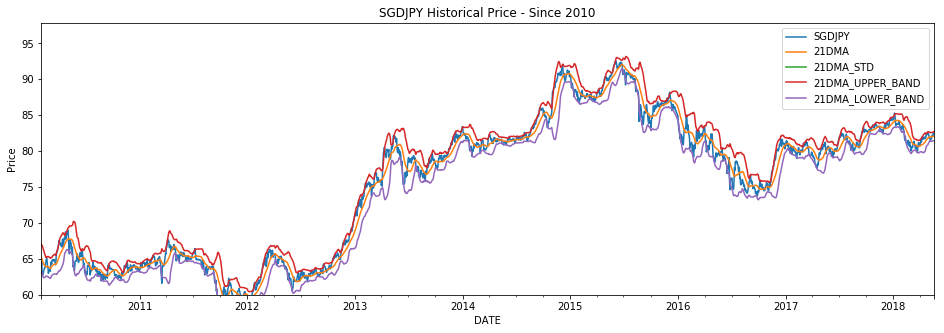

In [34]:
# on average, there's 21 trading days in a month
df_ma = df_orig.copy()
df_ma['21DMA'] = df_ma[ccy1ccy2].rolling(window=21).mean()
df_ma['21DMA_STD'] = df_ma[ccy1ccy2].rolling(window=21).std()
df_ma = df_ma.dropna()

# 2*Standard Deviation is akin to creating a bollinger band
df_ma['21DMA_UPPER_BAND'] = df_ma['21DMA'] + 2*df_ma['21DMA_STD']
df_ma['21DMA_LOWER_BAND'] = df_ma['21DMA'] - 2*df_ma['21DMA_STD']

fig_ma = df_ma.plot(figsize=(16,5))
_ = fig_ma.set_title(ccy1ccy2 + ' Historical Price - Since 2010')
_ = fig_ma.set_ylabel('Price')
_ = fig_ma.set_ylim(ymin=60)

## Moving Average

In [35]:
now = datetime.datetime.now()

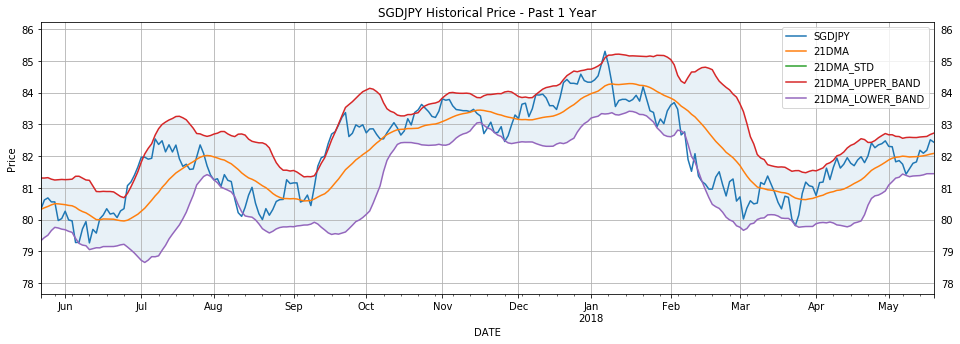

In [36]:
today_minus1Year = now.date() - datetime.timedelta(days=365)
df_ma_past1Year = df_ma.loc[today_minus1Year:]
fig_ma_past1Year = df_ma_past1Year.plot(figsize=(16,5), grid=True)
_ = fig_ma_past1Year.set_title(ccy1ccy2 + ' Historical Price - Past 1 Year')
_ = fig_ma_past1Year.set_ylabel('Price')
_ = fig_ma_past1Year.tick_params(labelright=True)
_ = fig_ma_past1Year.set_ylim(ymin=df_ma_past1Year['21DMA_LOWER_BAND'].min()-1, ymax=df_ma_past1Year['21DMA_UPPER_BAND'].max()+1)
_ = fig_ma_past1Year.fill_between(df_ma_past1Year.index, df_ma_past1Year['21DMA_LOWER_BAND'], df_ma_past1Year['21DMA_UPPER_BAND'], alpha=0.1)

## Standard Deviation vs Bid/Ask Spread

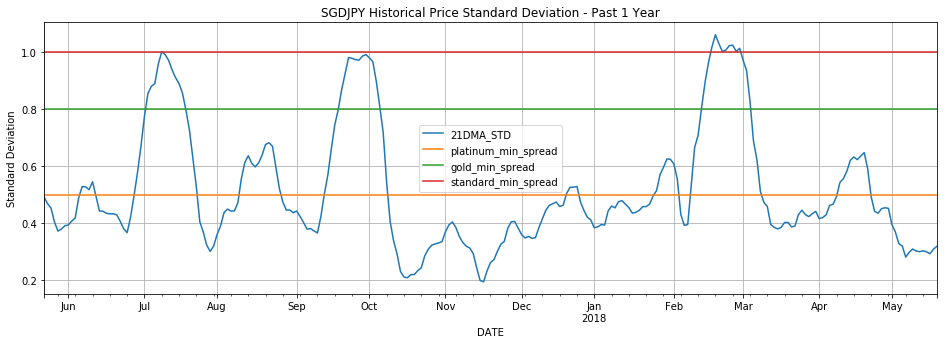

In [37]:
df_ma_past1Year['platinum_min_spread'] = platinum_spread
df_ma_past1Year['gold_min_spread'] = gold_spread
df_ma_past1Year['standard_min_spread'] = standard_spread
fig_ma_past1Year_std = df_ma_past1Year[['21DMA_STD','platinum_min_spread','gold_min_spread','standard_min_spread']].plot(figsize=(16,5), grid=True)
_ = fig_ma_past1Year_std.set_ylabel('Standard Deviation')
_ = fig_ma_past1Year_std.set_title(ccy1ccy2 + ' Historical Price Standard Deviation - Past 1 Year')

## Relative Strength Index

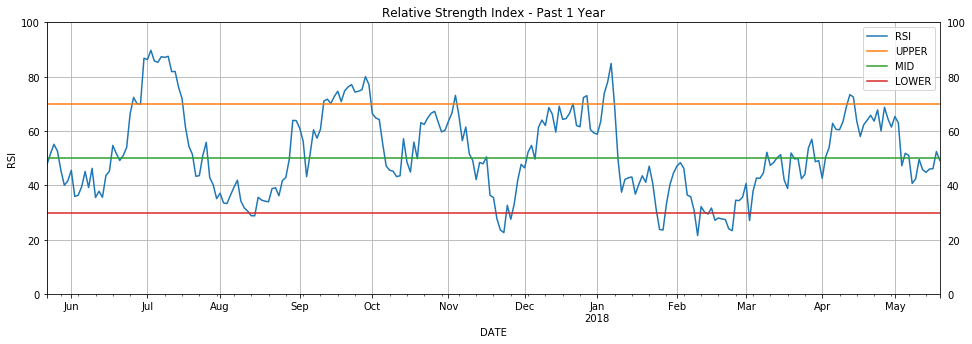

In [38]:
rsi_periods = 14; rsi_upper = 70; rsi_mid = 50; rsi_lower = 30
df_rsi = df_orig.copy()
df_rsi['DIFF'] = df_rsi.diff()
df_rsi = df_rsi.dropna()
df_rsi['GAIN'] = abs(np.where(df_rsi['DIFF']>=0, df_rsi['DIFF'], 0))
df_rsi['LOSS'] = abs(np.where(df_rsi['DIFF']<0, df_rsi['DIFF'],0))
df_rsi = df_rsi.rolling(window=rsi_periods).mean().dropna()[['GAIN','LOSS']]
df_rsi['RS'] = df_rsi['GAIN'] / df_rsi['LOSS']; df_rsi['RSI'] = 100 - (100 / (1 + df_rsi['RS']))
df_rsi['UPPER'] = rsi_upper; df_rsi['MID'] = rsi_mid; df_rsi['LOWER'] = rsi_lower
df_rsi_past1Year = df_rsi.loc[today_minus1Year:]
fig_rsi = df_rsi_past1Year[['RSI','UPPER','MID','LOWER']].plot(figsize=(16,5), title='Relative Strength Index - Past 1 Year', grid=True)
_ = fig_rsi.set_ylabel('RSI')
_ = fig_rsi.tick_params(labelright=True)
_ = fig_rsi.set_ylim(ymin=0, ymax=100)